In [1]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
import torch.distributions as dist
import pickle
from tqdm import tqdm
import numpy as np

In [2]:
with open('dataset.pickle', 'rb') as f:
    data = pickle.loads(f.read())
mapping = data['mapping']

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = np.array(X).astype(np.float32)
        self.y = np.array(y).astype(np.float32)
        assert self.X.shape[0]==self.y.shape[0]

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]


X_train, X_test, y_train, y_test, train_labels, test_labels = train_test_split(data['X'], data['y_regression'], data['y'], test_size=0.20)

In [4]:
train_dataset = Dataset(X_train, y_train)
test_dataset = Dataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()        

        self.net = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(X_train[0].shape[0], 256),
            nn.ReLU(),     
        )
        self.lin1 = nn.Linear(256, 2)
        self.lin2 = nn.Linear(256, 2)

        self.activation = nn.Tanh()
        self.activation2 = nn.Softplus()
    
    def forward(self, x):
        x = self.net(x)
        mean = self.lin1(x)
        mean = self.activation(mean)

        sigma = self.lin2(x)
        sigma = self.activation2(sigma)
        return mean, sigma

net = RegressionModel().cuda()
model.load_state_dict(torch.load('regression_model'))

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.0001)

In [22]:
t = tqdm(range(1000))
losses = []
val_losses = []
f1_scores = []
best_f1 = 0
for epoch in t:  # loop over the dataset multiple times
    total_loss = 0
    net.train(True)
    for i, data in enumerate(train_loader, 0):
        inputs, targets = data
        inputs = inputs.cuda()
        targets = targets.cuda()
        optimizer.zero_grad()
        mean, sigma = net(inputs)
        d = dist.Independent(dist.Normal(mean, sigma), 1)
        # loss = criterion(outputs, targets)
        loss = -d.log_prob(targets).mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.cpu().item()

    train_loss = total_loss/(i+1)
    losses.append(train_loss)

    total_loss = 0
    pred = []
    net.train(False)
    for i, data in enumerate(test_loader, 0):
        inputs, targets = data
        inputs = inputs.cuda()
        targets = targets.cuda()
        # outputs = net(inputs)
        # loss = criterion(outputs, labels)
        mean, sigma = net(inputs)
        # print(mean.shape, sigma.shape, targets.shape)
        d = dist.Independent(dist.Normal(mean, sigma), 1)
        loss = -d.log_prob(targets).mean()
        total_loss += loss.cpu().item()


    val_loss = total_loss/(i+1)
    val_losses.append(val_loss)
    t.set_description(f'loss : {train_loss:.6f}, val_loss: {val_loss:.6f}')

print('Finished Training')

loss : 0.538336, val_loss: 0.730553:  61%|██████▏   | 614/1000 [32:17<20:17,  3.15s/it]


KeyboardInterrupt: 

In [24]:
torch.save(net.state_dict(), 'regression_model')

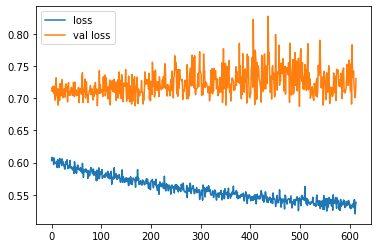

In [25]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
# smooth_loss = savgol_filter(losses, 51, 3)

plt.plot(losses, label='loss')
plt.plot(val_losses, label='val loss')
# plt.plot(smooth_loss, label='smooth loss')
plt.legend()
plt.show();

In [8]:
# plt.plot(f1_scores, label='f1')
# smooth_f1 = savgol_filter(f1_scores, 101, 3)
# plt.plot(smooth_f1, label='smooth f1')
# plt.legend()
# plt.show();

In [18]:
net.train(False)
points = []
sigmas = []
for i, data in enumerate(test_loader, 0):
    inputs, _ = data
    inputs = inputs.cuda()
    loc, sigma = net(inputs)
    points.append(loc.detach().cpu().numpy())
    sigmas.append(sigma.detach().cpu().numpy())

points = np.concatenate(points)
sigmas = np.concatenate(sigmas)
labels = test_labels

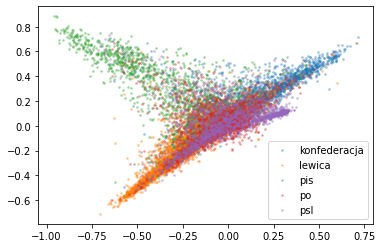

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(5):
    ax.scatter(points[labels==i][:,0], points[labels==i][:,1], label=mapping[i], alpha=0.3, s=3)

plt.legend()
plt.show();

In [21]:
with open('points.txt', 'w') as f:
    for point, sigma, label in zip(points, sigmas, labels):
        f.write(f'{point[0]} {point[1]} {sigma[0]} {sigma[1]} {label}\n') 

In [11]:
import plotly.graph_objects as go
import numpy as np

colors = [
    'red', 'green', 'blue', 'orange', 'violet'
]

fig = go.Figure()

for point, sigma, label in zip(points, sigmas, labels):
    fig.add_shape(type="circle",
        xref="x", yref="y",
        x0=point[0]-sigma[0], y0=point[1]-sigma[1],
        x1=point[0]+sigma[0], y1=point[1]+sigma[1],
        opacity=min([0.001/sigma[0]/sigma[1], 1.0]),
        fillcolor=colors[label],
        line_color=colors[label],
    )

# fig = go.Figure(data=[go.Scatter3d(x=points[labels==i][:,0], y=points[labels==i][:,1], z=points[labels==i][:,2],
#                                    mode='markers', marker=dict(size=3)) for i in range(5)])
fig.show()

KeyboardInterrupt: 

In [67]:
fig.show()